## **Prologue**


Kali ini saya akan mencoba untuk memprediksi journey time dari taxi trip di New York City. Saya akan mencoba memprediksi menggunakan beberapa feature yang ada, seperti pickup time stamp, ride start, dan destination coordinates (latitude, longitude).
Namun saya akan membuat kasus kecil, sehingga kita dapat lebih terperinci dalam mencari solusi dari problem tersebut.
Anggap saja kali ini kita ingin mengetahui trip terakhir dari Manhattan.

Lalu, apa yang akan kita analisis?
Sebelumnya, agar lebih mengerti, kita harus mengetahui stuktur data yang akan kita analisis.

**Variable**
Pertama-tama kita harus mengetahui variable independent yang ada dalam data kita, lalu cari tahu bagaimana korelasinya terhadap variable dependent.

**Jenis Variable**
Dalam data New York Taxi Trip ini terdapat Categorical dan Numerical variable.
Variable Categorical artinya variable yang nilainya dapat dikelompokkan ke dalam kategori seperti 1 atau 2, tinggi / sedang / rendah, Benar / Salah.
Sedangkan variable Numerical adalah variable yang nilainya bilangan bulat atau mengambang.

**Segmen**
Untuk mengetahui insight dari data yang berupa datetime dan titik koordinat, kita harus mengetahui soal Temporal dan Spasial variable.
Temporal berarti data yang berupa deret waktu yang nilainya dicatat menurut urutan waktu misalnya Tanggal, bulan, jam.
Sedangkan spasial adalah data geografis yaitu lokasi, koordinat lintang / bujur.

**Seasonal**
Apakah jumlah perjalanan taksi meningkat dalam periode kalender tertentu? Misalnya, selama hari libur umum, festival, atau tempat bisnis tertentu?

**Tren**
Rata-rata dari jumlah perjalanan, apakah meningkat atau berkurang dari waktu ke waktu?

**Cyclic Movement**
Apakah ada siklus atau periode jangka panjang yang tidak terkait dengan faktor musiman?

**Analisis Fitur Spasial**

Clustering - Mengelompokkan lokasi dalam data yang umumnya memakan waktu lebih lama / lebih singkat?

Jarak - Hitung jarak antara lokasi pickup dan dropoff.

Kecepatan - Hitung kecepatan naik taksi.

**Inconsistency Data:**

Gaps - Apakah ada nilai yang hilang dalam data?

Outliers - Apakah ada? Outliers dapat mempengaruhi kesimpulan dengan kuat, dan bisa menyesatkan.

**Kesimpulan:**
Kesimpulan untuk setiap jenis analisis / variabel

## **Import Libraries**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# from mpl_toolkits.basemap import Basemap
from matplotlib import cm

import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np

from haversine import haversine
from scipy.spatial.distance import euclidean , cityblock
from geopy.distance import great_circle
from math import *

from bokeh.io import output_notebook,show
from bokeh.models import HoverTool
from bokeh.plotting import figure
from bokeh.palettes import Spectral4

import folium 
from folium import plugins
from folium.plugins import HeatMap

output_notebook()

Loading BokehJS ...

## **Load Data**

In [2]:
train=pd.read_csv("train.csv")
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
test=pd.read_csv("test.csv")
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


## **Mari kita melihat pemandangan kota New York dengan Animated HeatMap**

Langkah pertama adalah tetapkan tema!
Mari kita plot kota New York yang indah dengan menggunakan feature pickup and dropoff coordinates.

Kami akan menggunakan Folium untuk memploting ini.

Namun ada beberapa titik koordinat yang jauh dari kota New York. Nah untuk mengatasinya mari kita gunakan feature filtering.

In [4]:
west, south, east, north = -74.03, 40.63, -73.77, 40.85

train = train[(train['pickup_latitude']> south) & (train['pickup_latitude'] < north)]
train = train[(train['dropoff_latitude']> south) & (train['dropoff_latitude'] < north)]
train = train[(train['pickup_longitude']> west) & (train['pickup_longitude'] < east)]
train = train[(train['dropoff_longitude']> west) & (train['dropoff_longitude'] < east)]

In [5]:
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['dropoff_month'] = train['dropoff_datetime'].dt.month

heat_df =train.sample(n=2500)

heat_df = heat_df[['dropoff_latitude', 'dropoff_longitude','dropoff_month']]

heat_df['dropoff_latitude'] = heat_df['dropoff_latitude'].astype(float)
heat_df['dropoff_longitude'] = heat_df['dropoff_longitude'].astype(float)


#remove NAN values
heat_df = heat_df.dropna(axis=0)

heat_df['Weight'] = heat_df['dropoff_month']
heat_df['Weight'] = heat_df['Weight'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['dropoff_latitude','dropoff_longitude', 'Weight'])

In [6]:
newyork_on_heatmap = folium.Map(location=[40.767937,-73.982155 ],tiles= "Stamen Terrain",
                    zoom_start = 13) 

heat_data = [[[row['dropoff_latitude'],row['dropoff_longitude']] 
                for index, row in heat_df[heat_df['Weight'] == i].iterrows()] 
                 for i in range(0,6)]

hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(newyork_on_heatmap)

newyork_on_heatmap

**Objective:**
Ini adalah lokasi drop off di seluruh kota New York.
Kita bisa lihat ada beberapa sign dalam maps, hal tersebut adalah drop off koordinat, yang ditampilkan setiap bulan dari Januari hingga Juni.

Mari kita lihat statis menggunakan BaseMap.

## **Pickups and Dropoff locations**

Sekarang mari kita lihat secara terpisah pickup dan dropoff untuk memahami di mana lokasi pickup dan lokasi drop off.

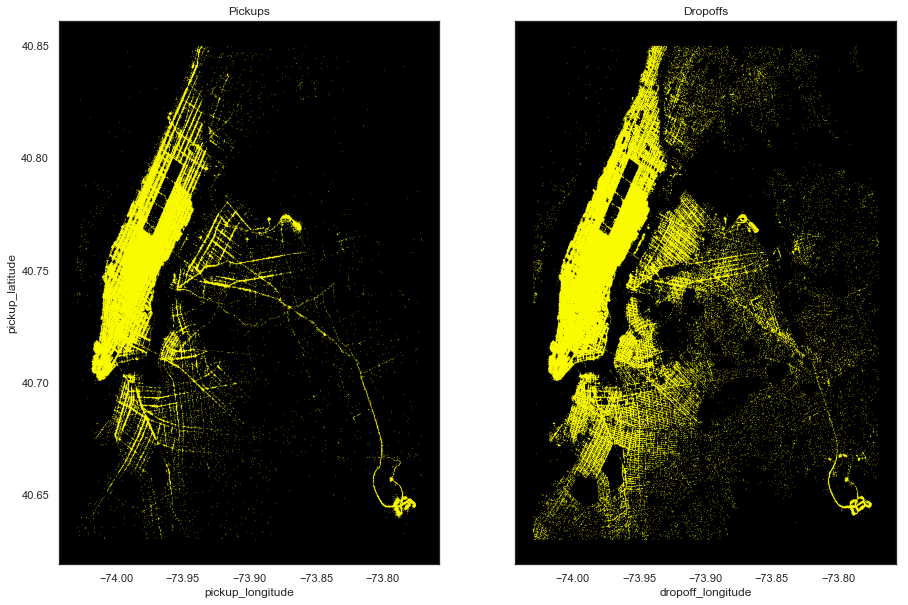

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black')

**Objective:**

Seperti yang bisa kita lihat di map, Manhattan terlihat cukup terang. Lokasi lain yang terlihat terang adalah di bandara John F. Kennedy dan bandara LA Guardia di Queens.
Ada 2 titik yang merupakan tempat paling sering pickup, pertama adalah Manhattan, dan kedua dibagian utara central park yang merupakan area bisnis.
Ternyata kawasan dropoff tersebar di seluruh kota New York.

## **Explore Data**

Mari kita memvisualisasikan berapa banyak pengamatan dan kolom yang ada di data train dan data test.

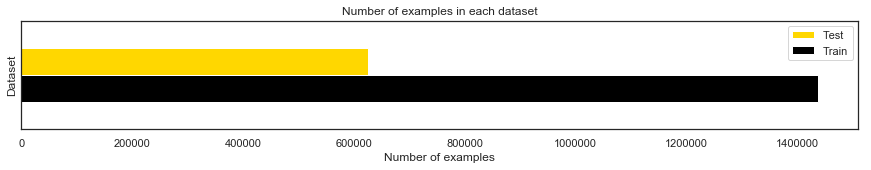

In [8]:
pd.DataFrame({'Train': [train.shape[0]], 'Test': [test.shape[0]]}).plot.barh(
figsize = (15,2), legend= 'reverse', color=['black','gold'])
plt.title('Number of examples in each dataset')
plt.ylabel('Dataset')
plt.yticks([])
plt.xlabel('Number of examples')
plt.show()

In [9]:
print("Training headcount is %i." % train.shape[0])
print("Testing headcount is %i." % test.shape[0])

Training headcount is 1438626.
Testing headcount is 625134.


Text(0.5,0,'Number of columns')

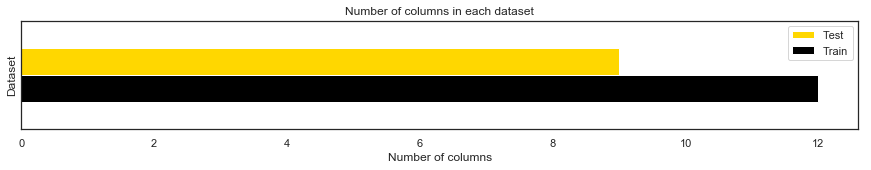

In [10]:
pd.DataFrame({'Train': [train.shape[1]],'Test': [test.shape[1]]}).plot.barh(
figsize=(15,2), legend='reverse', color=['black','gold'])
plt.title('Number of columns in each dataset')
plt.ylabel('Dataset')
plt.yticks([])
plt.xlabel('Number of columns')

**Objective:**
Terdapat 11 kolom dalam data train dan 9 kolom dalam data test karena durasi perjalanan dan waktu dropoff tidak ada dalam data test.

## **Describing the data**

In [11]:
pd.set_option('display.float_format', lambda i: '%.2f' % i)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dropoff_month
count,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,945.99,3.52
std,0.50,1.31,0.04,0.03,0.03,0.03,5252.16,1.68
min,1.00,0.00,-74.03,40.63,-74.03,40.63,1.00,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,394.00,2.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,656.00,4.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1059.00,5.00
max,2.00,6.00,-73.77,40.85,-73.77,40.85,3526282.00,7.00


**Objective:**

Dilihat dari tabel di atas, tidak ada missing values. Namun jika diperhatikan ada beberapa outliers, misalnya jumlah minimum penumpang adalah 0. Perhatikan juga durasi minimum perjalanan yang hanya 1 detik, itu artinya tidak kemana-mana. Ada juga jumlah maksimum perjalanan yang mencapai 35,26.282 detik atau 979,5 jam. Saya tidak yakin ada orang yang menggunakan taksi selama itu.

In [12]:
test.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.00,625134.00,625134.00,625134.00,625134.00,625134.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75
std,0.50,1.31,0.07,0.03,0.07,0.04
min,1.00,0.00,-121.93,37.39,-121.93,36.60
25%,1.00,1.00,-73.99,40.74,-73.99,40.74
50%,2.00,1.00,-73.98,40.75,-73.98,40.75
75%,2.00,2.00,-73.97,40.77,-73.96,40.77
max,2.00,9.00,-69.25,42.81,-67.50,48.86


## **Analyze Variable**

Dimulai dari menganalisis variabel independen dan hubungannya dengan target agar kita dapat mengetahui bagaimana sebenarnya variabel independen dan variable target saling berpengaruh. Kita juga akan mencari tahu seberapa penting variabel independen atau transformasinya untuk memprediksi variable target.

**Univariate Analysis**

Menganalisis variabel independen pada suatu waktu

**Trip duration**

Kita akan memploting durasi perjalanan setiap naik taksi, variabel target disebut juga sebagai variabel dependen

Text(0.5,1,'Trip Duration for each Taxi ride')

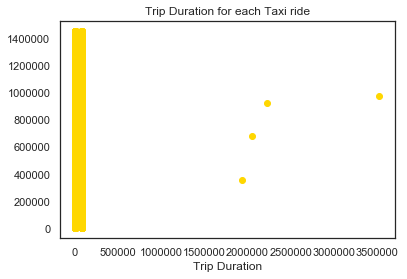

In [13]:
plt.scatter(train.trip_duration,train.index,color="gold")
plt.xlabel("Trip Duration")
plt.title("Trip Duration for each Taxi ride")

**Objective:**

Sepertinya beberapa perjalanan terlalu jauh dari kota New York (Perjalanan panjang siapa yang tahu). Ini termasuk outlier. Karena metrik evaluasi adalah RMSLE (Root Mean Squared Logarithmic Error), jadi kita bisa log transform durasi perjalanan dan menggunakan RMSE (Root Mean Squared Error) untuk training. Sehingga outlier tidak akan terlalu memengaruhi kinerja model. Jangan lupa untuk mengambil eksponensial saat mengirimkan submission file.

In [14]:
train['log_trip_duration'] = np.log1p(train['trip_duration'].values)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


(array([3.20000e+01, 1.65000e+02, 2.85000e+02, 5.45000e+02, 3.84000e+02,
        5.92000e+02, 4.56000e+02, 6.78000e+02, 8.54000e+02, 9.98000e+02,
        1.30500e+03, 2.25500e+03, 4.45700e+03, 1.02110e+04, 2.16780e+04,
        4.53810e+04, 8.04200e+04, 1.27647e+05, 1.75705e+05, 2.13718e+05,
        2.24173e+05, 2.02836e+05, 1.52465e+05, 9.26210e+04, 4.56940e+04,
        2.08960e+04, 7.91300e+03, 1.89200e+03, 2.60000e+02, 5.30000e+01,
        2.90000e+01, 8.00000e+00, 2.00000e+01, 3.10000e+01, 2.70000e+01,
        3.30000e+01, 2.19000e+02, 1.68600e+03, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([ 0.69314718,  0.98079933,  1.26845149,  1.55610364,  1.8437558 ,
         2.13140795,  2.41906011,  2.70671226,  2.99436442,  3.28201657,
         3.56966872,  3.85732088,  4.14497303,  4.43262519,  4.72027734,
         5.0079295 ,  5.29558165,  5.58323381,  5

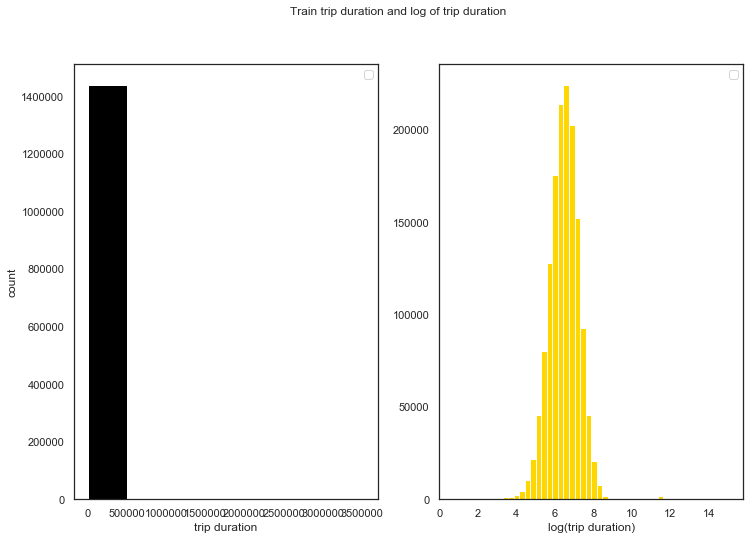

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,8))
fig.suptitle('Train trip duration and log of trip duration')
ax1.legend(loc=0)
ax1.set_ylabel('count')
ax1.set_xlabel('trip duration')
ax2.set_xlabel('log(trip duration)')
ax2.legend(loc=0)
ax1.hist(train.trip_duration,color='black',bins=7)
ax2.hist(train.log_trip_duration,bins=50,color='gold')

In [16]:
print("Skewness: %f" % train['log_trip_duration'].skew())
print("Kurtosis: %f" % train['log_trip_duration'].kurt())

Skewness: -0.265401
Kurtosis: 3.881358


## **Categorical Features**

**Siapa Vendor yang lebih disukai?**

Ok, siapa yang lebih baik di malam hari mengemudi

Text(0.5,0,'Vendor Id')

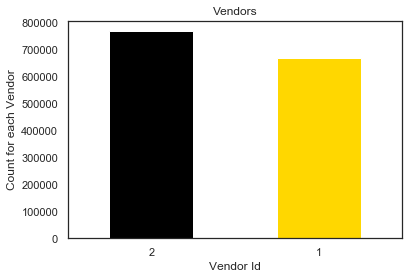

In [17]:
train["vendor_id"].value_counts().plot(kind='bar',color=["black","gold"])
plt.xticks(rotation='horizontal')
plt.title("Vendors")
plt.ylabel("Count for each Vendor")
plt.xlabel("Vendor Id")

**Objective:**

Ternyata hanya ada 2 Vendor saja, itu artinya ada 2 perusahaan taksi. Dari tabel di atas, terlihat lebih banyak vendor nomor 2 yang beroperasi.

**Lalu ada berapa banyak penumpang yang bepergian bersama?**

Text(0.5,0,'Number of Passengers')

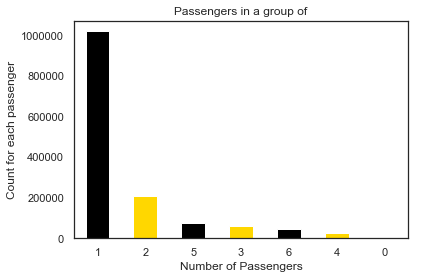

In [18]:
train['passenger_count'].value_counts().plot(kind='bar',color=['black','gold'])
plt.title('Passengers in a group of')
plt.xticks(rotation='horizontal')
plt.ylabel('Count for each passenger')
plt.xlabel('Number of Passengers')

**Objective:**

Pilihan perjalanan paling populer adalah single.
Di urutan kedua adalah penumpang yang berjumlah dua orang.
Herannya, penumpang dengan jumlah 5 orang menempati posisi ketiga, ada kemungkinan ini adalah taksi dengan mobil bertipe panjang.

Ada 60 perjalanan dengan nol penumpang. Itu adalah outlier. Karena tidak mungkin ada tumpangan taksi yang bisa terjadi tanpa penumpang.

**Apakah Rincian Perjalanan Disimpan Atau Diteruskan?**

Text(0.5,0,'Flag')

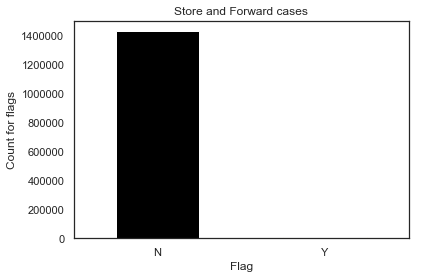

In [19]:
train["store_and_fwd_flag"].value_counts().plot(kind='bar',color=["black","gold"])
plt.title("Store and Forward cases")
plt.xticks(rotation='horizontal')
plt.ylabel("Count for flags")
plt.xlabel("Flag")

**Objective:**

Hampir semua detail perjalanan segera dikirim ke vendor. Sangat sedikit yang tersimpan dalam memori perangkat mungkin karena sinyal buruk atau cuaca buruk.

## **Feature Engineering**

Bagaimana dengan Tanggal dan waktu perjalanan?
Kita bisa mendapatkan insight dari data tanggal dan waktu yang kita miliki.

Trip pada jam sibuk dapat menentukan mulai dari jam berapa waktu kantor di kota New York. Dan dropoff yang terjadi di malam hari dapat menentukan sampai jam berapa New York bekerja.
Hari kerja dan akhir pekan dapat menunjukkan sudut lain kehidupan kota. Orang-orang di akhir pekan akan bangun terlambat dan memulai hari lebih lambar dibandingkan dengan hari kerja. Party pada akhir pekan juga bisa melampaui jam tengah malam.
Kita juga bisa melihat beberapa jenis habbit pada setiap musim. Misalnya, selama musim dingin, lalu lintas akan melambat karena hujan salju atau hujan di jalan. Jadi, Durasi perjalanan akan lebih lama di musim dingin daripada musim lainnya.

In [20]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)


for df in (train,test):
    # Dates
    df['pickup_date'] = df['pickup_datetime'].dt.date

    # day of month 1 to 30/31
    df['pickup_day'] = df['pickup_datetime'].dt.day

    #month of year 1 to 12
    df['pickup_month'] = df['pickup_datetime'].dt.month

    #weekday 0 to 6
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday


    #week of year
    df['pickup_weekofyear'] = df['pickup_datetime'].dt.weekofyear

    #hour of day 0 to 23
    df['pickup_hour'] = df['pickup_datetime'].dt.hour

    #minute of hour
    df['pickup_minute'] = df['pickup_datetime'].dt.minute

    # day of year
    df['pickup_dayofyear'] = df['pickup_datetime'].dt.dayofyear

train['pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train['pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test['pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test['pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

**Seasonality** 

Pola habbit pada saat menggunakan taksi dapat dipengaruhi oleh faktor musim (misalnya, Kuartal tahun, bulan, atau hari dalam seminggu). Musim selalu merupakan periode yang pasti dan diketahui. Oleh karena itu, deret waktu seasonal kadang-kadang disebut time series.

Mari cari tahu pola seasonal di data kita.

**Taxi trip by months**

Text(0.5,1,'Total trips in each month')

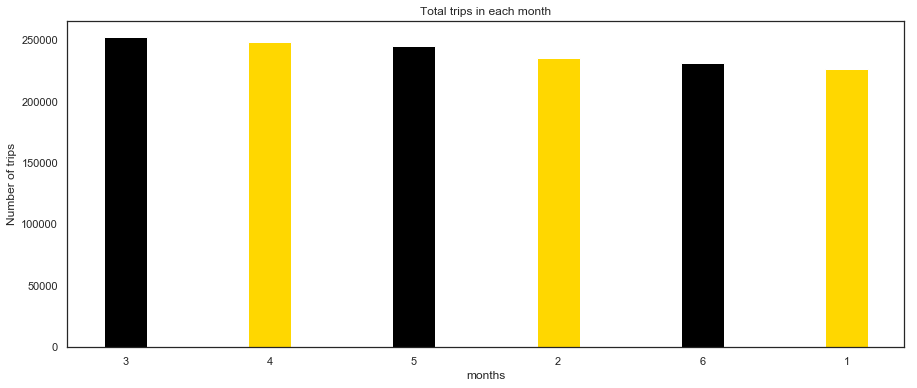

In [21]:
plt.figure(figsize=(15, 6)) 
train.pickup_month.value_counts().plot(kind='bar',color=["black","gold"],align='center',width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("months")
plt.ylabel("Number of trips")
plt.title("Total trips in each month")

**Objective:**

Kita memiliki data dari Januari hingga Juni 2016. Jumlah perjalanan tertinggi terjadi pada Maret dan terendah pada Januari.

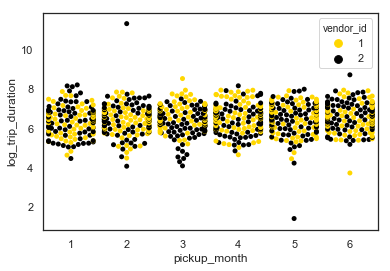

In [22]:
sns.swarmplot(train.pickup_month[:1000],train.log_trip_duration[:1000],hue=train.vendor_id[:1000],palette={1:'gold',2:'black'})

**Objective:**

Tidak ada yang dapat dibedakan di sini, terdapat beberapa outlier di sana-sini. Kontribusi vendor kurang lebih sama. Ada hubungan linear antara Bulan dan Durasi Perjalanan.

## **Taxi Trips By Pickup Dates**

In [23]:
tripsByDate=train['pickup_date'].value_counts()

# Basic plot setup
plot = figure( x_axis_type="datetime", tools="",
              toolbar_location=None, x_axis_label='Dates',
            y_axis_label='Taxi trip counts', title='Hover over points to see taxi trips')

x,y= tripsByDate.index, tripsByDate.values
plot.line(x,y, line_dash="4 4", line_width=1, color='gold')

cr = plot.circle(x, y, size=20,
                fill_color="gold", hover_fill_color="black",
                fill_alpha=0.05, hover_alpha=0.5,
                line_color=None, hover_line_color="black")
plot.left[0].formatter.use_scientific = False

plot.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='hline'))

show(plot)

**Objective:**

Plotting di atas memberikan penjelasan secara detail tentang semua perjalanan taksi yang terjadi pada tanggal-tanggal tertentu. Spike terendah terjadi sekitar akhir Januari. Wajar saja, karena pada saat itu terjadi hujan salju yang lebat di New York, tepatnya pada tanggal 23 dan 24 Januari. April dan Maret adalah bulan-bulan sibuk yang tercatat dengan jumlah pickup terbanyak.

In [24]:
print("Highest number of pickups: ", tripsByDate[0] , "happened on", str(tripsByDate.index[0]))
print("And lowest number of pickups: ", tripsByDate[tripsByDate.size-1] , "happened on",
      str(tripsByDate.index[tripsByDate.size-1]), "due to heavy snowfall in New York.")

Highest number of pickups:  9681 happened on 2016-04-09
And lowest number of pickups:  1624 happened on 2016-01-23 due to heavy snowfall in New York.


**Mari kita plot trip pada saat salju dan tujuannya**

In [25]:
snowFallDF=train[(train['pickup_dayofyear'] == 24) |  (train['pickup_dayofyear'].any() == 23)]
snowFallDF.shape

(3337, 23)

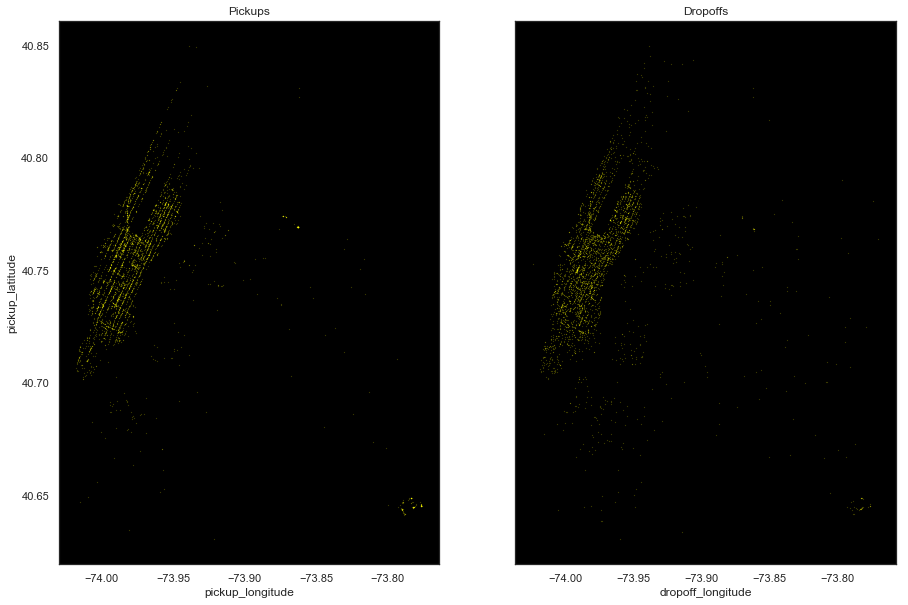

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

snowFallDF.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

snowFallDF.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black') 

**Objective:**

Sepertinya sangat sedikit trip karena hujan salju lebat. Saat melakukan feature engineering, kita akan mendapatkan bantuan dataset cuaca eksternal, yang memiliki informasi salju turun di New York.

## **Taxi Trips By Dropoff Date**

In [27]:
train['dropoff_date'] = train['dropoff_datetime'].dt.date
tripsByDropoffDate=train['dropoff_date'].value_counts()

# Basic plot setup
plot = figure( x_axis_type="datetime", tools="",
              toolbar_location=None, x_axis_label='Dates',
            y_axis_label='Taxi trip counts', title='Hover over points to see taxi trips')

x,y= tripsByDropoffDate.index, tripsByDropoffDate.values
plot.line(x,y, line_dash="4 4", line_width=1, color='gold')

cr = plot.circle(x, y, size=20,
                fill_color="gold", hover_fill_color="black",
                fill_alpha=0.05, hover_alpha=0.5,
                line_color=None, hover_line_color="black")
plot.left[0].formatter.use_scientific = False

plot.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='hline'))

show(plot)
train.drop('dropoff_date',axis=1,inplace=True)

**Objective:**

Spike terendah sekitar akhir Juni dan awal Juli. Kita memiliki data dropoff tambahan 1 hari dalam dataset training dan Maret adalah bulan-bulan sibuk yang tercatat dengan jumlah pickup terbanyak.

In [28]:
print("Highest number of dropoffs: ", tripsByDropoffDate[0] , "happened on", str(tripsByDropoffDate.index[1]))
print("And lowest number of dropoffs: ", tripsByDropoffDate[tripsByDropoffDate.size-1] , "happened on",
      str(tripsByDropoffDate.index[tripsByDropoffDate.size-1]))

Highest number of dropoffs:  9681 happened on 2016-03-05
And lowest number of dropoffs:  123 happened on 2016-07-01


## **Taxi Trips By Pickup Day of the Month**

Text(0.5,1,'Total trips on each day')

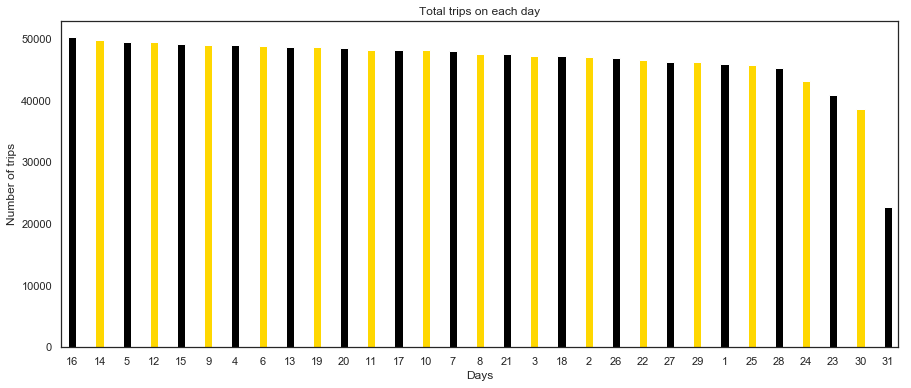

In [29]:
plt.figure(figsize=(15, 6)) 
train.pickup_day.value_counts().plot(kind='bar',color=["black","gold"],align='center',width=0.3)
plt.xlabel("Days")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of trips")
plt.title("Total trips on each day")

**Objective:**

Jumlah perjalanan tertinggi terjadi pada tanggal 16 bulan itu sedangkan terendah pada tanggal 31.
Tanggal 30 dan 31 memiliki lebih sedikit trip, karena kita memiliki data 6 bulan dan perjalanan tanggal 30 dan 31 hanya muncul masing-masing 3 kali.

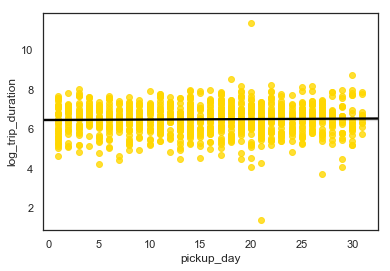

In [30]:
sns.regplot(train.pickup_day[:1000],train.log_trip_duration[:1000],color='gold', line_kws={'color':'black'});

**Objective:**

Durasi rata-rata perjalanan adalah sekitar 6,48. Jelas ada hubungan linear antara keduanya. Hmm !! Garis hitam solid menggambarkan fit model regresi linier.

## **Taxi Trips By Pickup WeekDays**

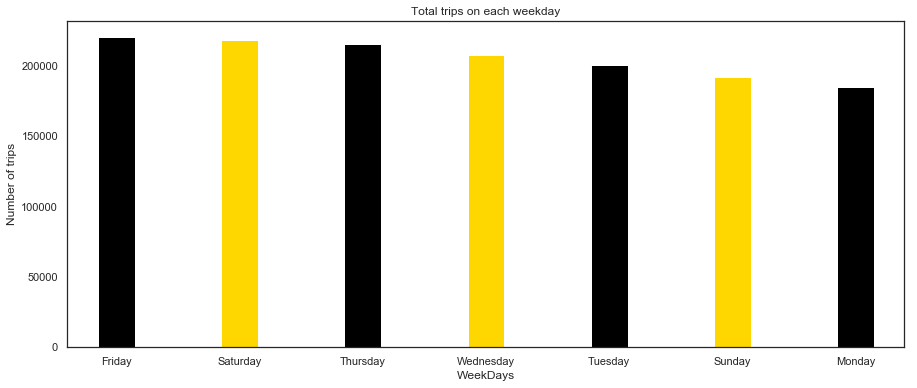

In [31]:
train['pickup_weekday_name'] = train['pickup_datetime'].dt.weekday_name
plt.figure(figsize=(15, 6)) 
train.pickup_weekday_name.value_counts().plot(kind='bar',color=["black","gold"],align='center',width=0.3)
plt.xlabel("WeekDays")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of trips")
plt.title("Total trips on each weekday");
train.drop('pickup_weekday_name',axis=1,inplace=True)

**Objective:**                                                                                         
                                                                                         
Jumlah perjalanan tertinggi terjadi pada setiap hari Jumat setiap minggu sedangkan terendah pada hari Senin. Hari Kamis dan Sabtu juga termasuk hari-hari sibuk.

## **Taxi Trips By Pickup Hour**

Text(0.5,1,'Total pickups at each hour')

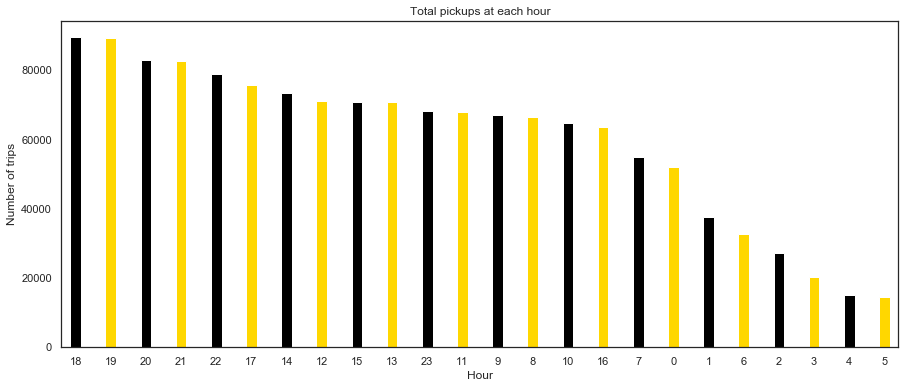

In [32]:
plt.figure(figsize=(15, 6)) 
train.pickup_hour.value_counts().plot(kind='bar',color=["black","gold"],align='center',width=0.3)
plt.xlabel("Hour")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of trips")
plt.title("Total pickups at each hour")

**Objective:**

Sebagian besar pickup berada di jam 6 malam, mungkin karena orang-orang pulang dari kantor dan paling lama pada jam 5 dini hari. Permintaan pick up dimulai dari jam 6 pagi dan terus bertambah seiring hari.

## **Taxi trips by pickup hour and trip duration**

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


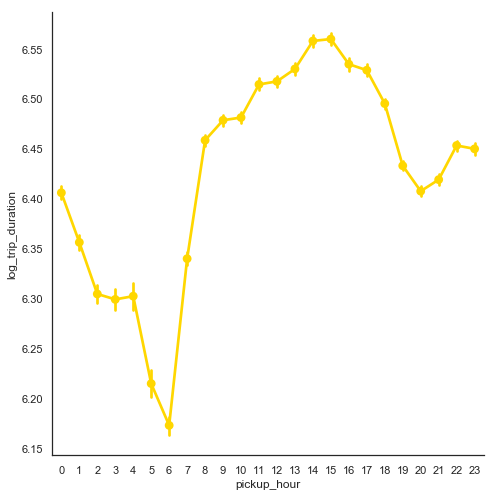

In [33]:
sns.factorplot(x="pickup_hour", y="log_trip_duration", data=train,color='gold',size=7)

**Objective:**

Durasi perjalanan terendah pada pagi hari melewati tengah malam. Mungkin orang tidak mau berjalan dalam kegelapan atau mungkin karena terlalu hangover setelah party jadi memilih naik taksi daripada berkendara sendiri.
Lalu lintas mulai meningkat begitu pukul 8 pagi, karena orang mulai ke kantor dan mencapai puncak kemacetan sekitar jam 3 siang.
Kemudian mulai menurun perlahan-lahan dan sekali lagi memuncak setelah pukul 8 sampai akhir 11 malam. Mungkin karena orang pulang setelah jam kerja.

## **Taxi Trips By Dropoff Hour**

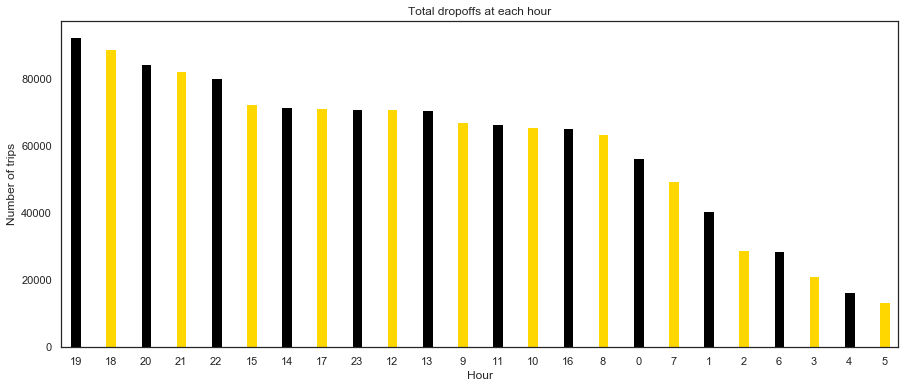

In [34]:
train['dropoff_hour'] = train['dropoff_datetime'].dt.hour
plt.figure(figsize=(15, 6)) 
train.dropoff_hour.value_counts().plot(kind='bar',color=["black","gold"],align='center',width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("Hour")
plt.ylabel("Number of trips")
plt.title("Total dropoffs at each hour");
train.drop('dropoff_hour',axis=1,inplace=True)

**Objective:**

Sebagian besar dropoff pada pukul 7malam hari, karena orang-orang meninggalkan tempat kerja dan pulang ke rumah. Paling lambat pukul 5 dini hari. Permintaan untuk dropoff di daerah perkantoran mulai tumbuh dari sekitar jam 9 dan terus meningkat seiring hari berjalan. Warga New York cenderung bekerja lembur karena dropoff berlangsung sampai jam 12 tengah malam dan perlahan-lahan berkurang setelah itu.

## **Taxi trips by pickup minute Vs. Trip Duration**

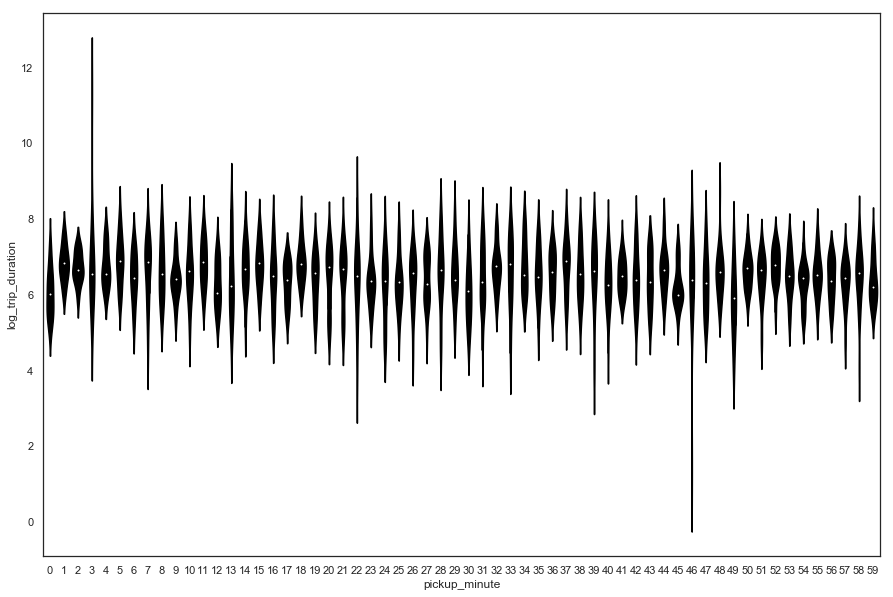

In [35]:
fig=plt.figure(figsize=(15,10))
sns.violinplot(x="pickup_minute", y="log_trip_duration", data=train[:1000],color='black');

**Objective:**

Ada lonjakan besar di menit 4 dan 47. Menit pickup juga sangat penting karena kita harus menghitung total durasi dalam detik. Hubungan linier dapat dari keduanya.

Mari kita ubah ini menjadi numerik.

In [36]:
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

Text(0.5,0,'Dropoff Longitude')

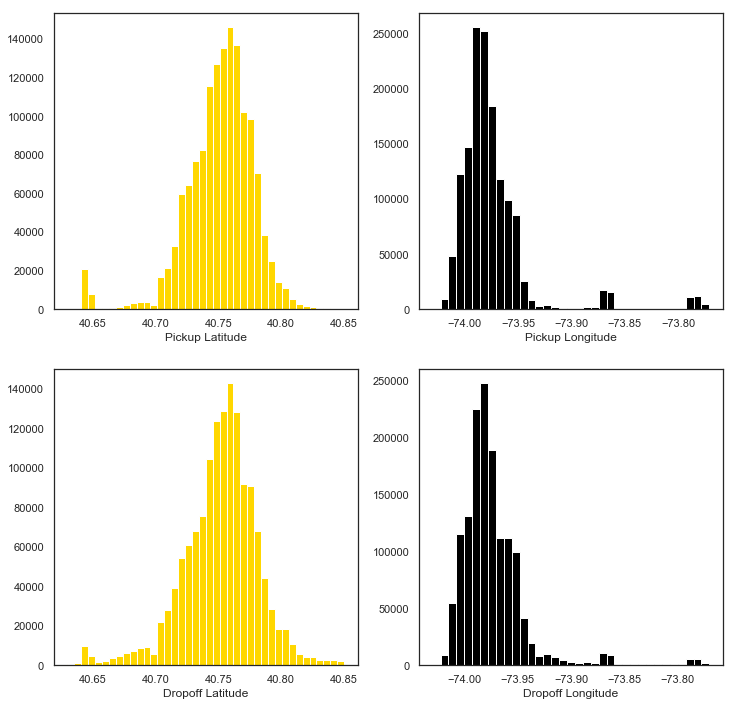

In [37]:
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(12, 12), sharex=False, sharey = False)
ax[0,0].hist(train.pickup_latitude.values,bins=40,color="gold")
ax[0,1].hist(train.pickup_longitude.values,bins=35,color="black")
ax[1,0].hist(train.dropoff_latitude.values,bins=40,color="gold")
ax[1,1].hist(train.dropoff_longitude.values,bins=35,color="black")
ax[0,0].set_xlabel('Pickup Latitude')
ax[0,1].set_xlabel('Pickup Longitude')
ax[1,0].set_xlabel('Dropoff Latitude')
ax[1,1].set_xlabel('Dropoff Longitude')

## **Let's Calculate Distance and Speed of the trips**

In [38]:
train=train[:100000]
test=test[:100000]

train['lat_diff'] = train['pickup_latitude'] - train['dropoff_latitude']
test['lat_diff'] = test['pickup_latitude'] - test['dropoff_latitude']

train['lon_diff'] = train['pickup_longitude'] - train['dropoff_longitude']
test['lon_diff'] = test['pickup_longitude'] - test['dropoff_longitude']

In [39]:
train['haversine_distance'] = train.apply(lambda row: haversine( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
test['haversine_distance'] = test.apply(lambda row: haversine( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
train['log_haversine_distance'] = np.log1p(train['haversine_distance']) 
test['log_haversine_distance'] = np.log1p(test['haversine_distance']) 

Text(0.5,1,'log(Haversine Distance) Vs log(Trip Duration)')

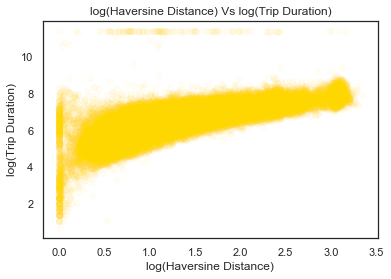

In [40]:
plt.scatter(train.log_haversine_distance,train.log_trip_duration,color="gold",alpha=0.04)
plt.ylabel("log(Trip Duration)")
plt.xlabel("log(Haversine Distance)")
plt.title("log(Haversine Distance) Vs log(Trip Duration)")

**Objective:**

Seperti yang dapat kita lihat dalam grafik di atas, jarak perjalanan menentukan batas terendah untuk durasi perjalanan. Mari kita hitung jarak Manhattan juga, karena kita berada di Manhattan.

In [41]:
def manhattan_distance(x,y):
  return sum(abs(a-b) for a,b in zip(x,y))

def euclidean_distance(x,y):
  return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

train['euclidean_distance'] = train.apply(lambda row: euclidean_distance( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
test['euclidean_distance'] = test.apply(lambda row: euclidean_distance( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
train['log_euclidean_distance'] = np.log1p(train['euclidean_distance']) 
test['log_euclidean_distance'] = np.log1p(test['euclidean_distance']) 

train['manhattan_distance'] = train.apply(lambda row: manhattan_distance( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
test['manhattan_distance'] = test.apply(lambda row: manhattan_distance( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
train['log_manhattan_distance'] = np.log1p(train['manhattan_distance']) 
test['log_manhattan_distance'] = np.log1p(test['manhattan_distance']) 

Text(0.5,1,'log(Manhattan Distance) Vs log(Trip Duration)')

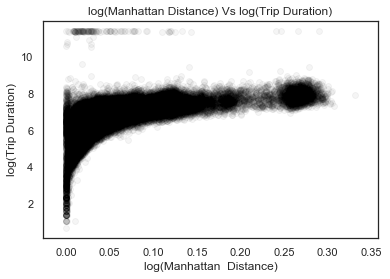

In [42]:
plt.scatter(train.log_manhattan_distance,train.log_trip_duration,color="black",alpha=0.04)
plt.ylabel("log(Trip Duration)")
plt.xlabel("log(Manhattan  Distance)")
plt.title("log(Manhattan Distance) Vs log(Trip Duration)")

**Mari kita hitung kecepatan**

In [43]:
train.loc[:, 'avg_speed_h'] = 1000 * train['haversine_distance'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['manhattan_distance'] / train['trip_duration']
train.loc[:, 'avg_speed_eu'] = 1000 * train['euclidean_distance'] / train['trip_duration']

test.loc[:, 'avg_speed_h'] = 1000 * test['haversine_distance'] / train['trip_duration']
test.loc[:, 'avg_speed_m'] = 1000 * test['manhattan_distance'] / train['trip_duration']
test.loc[:, 'avg_speed_eu'] = 1000 * test['euclidean_distance'] / train['trip_duration']

**Speed in Hour and week**

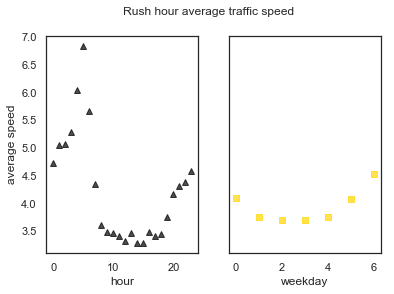

In [44]:
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], '^', lw=2, alpha=0.7,color='black')
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 's', lw=2, alpha=0.7,color='gold')
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

**Rute Tercepat**

In [45]:
fastest_routes1 = pd.read_csv('fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fastest_routes2 = pd.read_csv('fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_fastest_routes = pd.read_csv('fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_fastest_routes = pd.concat((fastest_routes1, fastest_routes2))
train = train.merge(train_fastest_routes, how='left', on='id')
test = test.merge(test_fastest_routes, how='left', on='id')

## **Model and Predictions**

In [46]:
target=train.log_trip_duration.values
train = train.drop(['id', 'pickup_datetime','dropoff_month', 'haversine_distance', 'manhattan_distance','euclidean_distance','avg_speed_h','avg_speed_m','avg_speed_eu','dropoff_datetime', 'trip_duration','log_trip_duration','pickup_date'], axis=1)
train.fillna(0,inplace=True)
train.dtypes

vendor_id                   int64
passenger_count             int64
pickup_longitude          float64
pickup_latitude           float64
dropoff_longitude         float64
dropoff_latitude          float64
store_and_fwd_flag          int32
pickup_day                  int64
pickup_month                int64
pickup_weekday              int64
pickup_weekofyear           int64
pickup_hour                 int64
pickup_minute               int64
pickup_dayofyear            int64
pickup_dt                 float64
pickup_week_hour            int64
lat_diff                  float64
lon_diff                  float64
log_haversine_distance    float64
log_euclidean_distance    float64
log_manhattan_distance    float64
total_distance            float64
total_travel_time         float64
number_of_steps             int64
dtype: object

In [47]:
Id=test.id.values
test = test.drop(['id','pickup_datetime','pickup_date','haversine_distance', 'manhattan_distance','euclidean_distance','avg_speed_h','avg_speed_m','avg_speed_eu'], axis=1)
test.fillna(0,inplace=True)
predictors=test.columns
test.dtypes

vendor_id                   int64
passenger_count             int64
pickup_longitude          float64
pickup_latitude           float64
dropoff_longitude         float64
dropoff_latitude          float64
store_and_fwd_flag          int32
pickup_day                  int64
pickup_month                int64
pickup_weekday              int64
pickup_weekofyear           int64
pickup_hour                 int64
pickup_minute               int64
pickup_dayofyear            int64
pickup_dt                 float64
pickup_week_hour            int64
lat_diff                  float64
lon_diff                  float64
log_haversine_distance    float64
log_euclidean_distance    float64
log_manhattan_distance    float64
total_distance            float64
total_travel_time         float64
number_of_steps             int64
dtype: object

## **Random Forest**

In [48]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=1000, min_samples_leaf=50, min_samples_split=75)

In [49]:
rf_model.fit(train.values, target)
predictions=rf_model.predict(test.values)
predictions[:5]

array([6.67674858, 6.28558449, 6.04613863, 6.91979574, 5.55360304])

## **Submission**

In [50]:
test['trip_duration'] = np.exp(predictions) - 1
test['id']=Id
test[['id', 'trip_duration']].to_csv('poonam.csv.gz', index=False, compression='gzip')
test['trip_duration'][:5]

0    792.73
1    535.78
2    421.48
3   1011.11
4    257.17
Name: trip_duration, dtype: float64

In [52]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

print('MAE:',mean_absolute_error(target,predictions))
print('MSE:',mean_squared_error(target,predictions))
print('RMSE:',np.sqrt(mean_squared_error(target,predictions)))
print('R2 Score:',r2_score(target,predictions))

MAE: 0.8104762682048262
MSE: 1.0810350925868706
RMSE: 1.0397283744261625
R2 Score: -0.7464137124217654


In [57]:
target[0]

6.1224928095143865

In [60]:
dicti = {'Prediction':predictions.reshape(1,-1)[0],
         'Actual':list(target),
        'Selisih':abs((predictions.reshape(1,-1)[0])-list(target)),
        'Selisih %': (abs((predictions.reshape(1,-1)[0])-list(target))/list(target))*100}
# print(dicti)
df_selisih = pd.DataFrame(dicti)
df_selisih.head()

,Prediction,Actual,Selisih,Selisih %
0,6.68,6.12,0.55,9.05
1,6.29,6.50,0.21,3.27
2,6.05,7.66,1.62,21.08
3,6.92,6.06,0.86,14.12
4,5.55,6.08,0.52,8.62


## **Feature Importance**

In [ ]:
importances=rf_model.feature_importances_
std = np.std([rf_model.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
plt.figure(figsize=(10,10))
plt.title("Feature Importances By Random Forest Model")
plt.barh(range(len(indices)), importances[indices],
       color=["black","gold"], yerr=std[indices], align="center")
plt.yticks(range(len(indices)), sorted_important_features, rotation='horizontal')